In [215]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from transformers import AutoTokenizer
from tqdm import tqdm
import seaborn as sns

# Use retina display for better quality
%config InlineBackend.figure_format = 'retina'

In [319]:
from datasets import Dataset, load_dataset

dataset_name = "HuggingFaceH4/MATH-500"
dataset_split = "test"
dataset = load_dataset(dataset_name, split=dataset_split)
levels = []
gt_answers = [
    row['answer']
    for row in dataset
]
levels = [
    row['level']
    for row in dataset
]

In [320]:
# model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_no_sample.json"
model_solutions_dir = "/root/tts_and_entropy/model_solutions/llama70b_with_sample_long_math500.json"

MAX_RANGE = 500

model_solutions = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions.append(json.loads(line.strip()))
model_solutions = model_solutions[:MAX_RANGE]
reason_lengths = []
reason_number_of_lines = []

model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

for row in model_solutions:
    # model_response = (row['response'])
    model_response  = row
    model_response = model_response.split('</think>')[0]
    reasoning_line = [''] + model_response.split('\n\n')
    # reasoning_line = model_response.split("<think>")[1].split('\n\n')
    # Extract reasoning length of each line
    reasoning_length = np.array([
        len(tokenizer(line)['input_ids']) for line in reasoning_line
    ])
    reasoning_length = np.cumsum(reasoning_length)[::2]
    reason_lengths.append(reasoning_length)
    reason_number_of_lines.append(len(reasoning_length))


def fine_line_with_max_token(reason_length, max_token=1024):
    """
    Find the line with the maximum token length that is less than or equal to max_token.
    """
    for i, length in enumerate(reason_length):
        if length > max_token:
            return i - 1
    return len(reason_length) - 1
    

In [321]:
def load_log(QID, acc_dir, entropy_dir, entropy_pattern, include_ans=False):
    tmp_dir = acc_dir
    entropy_base_dir = entropy_dir

    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )

    ENTROPY = np.load(
        os.path.join(entropy_base_dir, entropy_pattern.format(QID))
    )

    if include_ans:
        ANS = np.load(
            os.path.join(tmp_dir, f'all_extracted_answers_{QID}.npy')
        )
        ua = []
        for _A in ANS:
            ua.append(len(np.unique(_A)))
        return ACC, ENTROPY, np.array(ua), ANS
    
    return ACC, ENTROPY

In [322]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def compute_relative_changes(a):
    """
    Compute the relative changes of a sequence with a moving average window.
    """
    return np.abs(
        (a[1:] - a[:-1])
    )


def get_early_stop_point_posthoc(trace, threshold, min_distance=25, normalize=False):
    trace = trace[1:]
    for i, value in enumerate(trace):
        if i < min_distance:
            continue
        if value < threshold:
            return i
    return None

def exponential_moving_average(data, timescale):
    ema = np.zeros_like(data)
    ema[0] = data[0]
    
    for i in range(1, len(data)):
        ema[i] = timescale * data[i] + (1 - timescale) * ema[i - 1]
    
    return ema

def exponential_moving_variance(data, timescale, ema_0=0.0, normalize=False):
    ema_mean = exponential_moving_average(data, timescale)
    ema_variance = np.zeros_like(data)
    ema_variance[0] = ema_0
    
    for i in range(1, len(data)):
        deviation = data[i] - ema_mean[i]
        ema_variance[i] = timescale * (deviation ** 2) + (1 - timescale) * ema_variance[i - 1]

    return ema_variance

def simple_moving_average_variance(data, window_size=10):
    window = np.ones(window_size) / window_size
    mean_x = np.convolve(data, window, mode='valid')
    mean_x_sq = np.convolve(data**2, window, mode='valid')
    moving_var = mean_x_sq - mean_x**2
    # Pad the beginning of the moving variance to match the length of the original data
    moving_var = np.concatenate((np.zeros(window_size - 1), moving_var))
    return moving_var

def choose_early_stop_point(entropy, timescale, threshold, min_distance=25, ema_0=0.0, min_value_threshold=None, normalize=False):
    # if normalize:
    #     entropy = entropy / entropy[:2].mean()
    ema_variance = exponential_moving_variance(entropy, timescale, ema_0, normalize=normalize)
    if min_distance > len(entropy):
        return -1
    if min_value_threshold is not None:
        min_value_pos = np.argmax(entropy < min_value_threshold)
        min_distance = max(min_value_pos, min_distance)
    exit_idx = get_early_stop_point_posthoc(ema_variance, threshold, min_distance, normalize=normalize)
    return exit_idx if exit_idx is not None else -1

def choose_early_stop_point_moving_window(entropy, window_size, threshold):
    if window_size > len(entropy):
        return -1
    ema_variance = simple_moving_average_variance(entropy, window_size)
    # ema_variance = ema_variance / exponential_moving_average(entropy, timescale)
    exit_idx = get_early_stop_point_posthoc(ema_variance, threshold, window_size, normalize=False)
    return exit_idx if exit_idx is not None else -1

In [323]:
acc_dir = '/root/tts_and_entropy/outputs/cached_results_llama70b_math500'
entropy_dir = '/root/o1_test/entropies'
entropy_template = 'entropy_{}_new_dpsk_new_with_sample_ngram.npy'
entropy_template_with_final_ans = 'math500_entropy_llama70b_new_dpsk_new_with_sample_ngram_aime2025_full_{}.npy'
entropy_template_no_final_ans = 'math500_entropy_llama70b_new_dpsk_new_with_sample_ngram_aime2025_full_{}_no_final_ans.npy'

entropy_template_with_final_ans_small = 'math500_entropy_llama70b_new_dpsk_small_with_sample_ngram_aime2025_full_{}.npy'
entropy_template_no_final_ans_small = 'math500_entropy_llama70b_new_dpsk_small_with_sample_ngram_aime2025_full_{}_no_final_ans.npy'

all_accs, all_entropy, all_unique_answers, all_extracted_answers = [], [], [], []
all_entropy_with_final_ans = []
all_entropy_dpsk_small = []
all_entropy_with_final_ans_dpsk_small = []
for qid in tqdm(range(MAX_RANGE)):
    acc, entropy, unique_answers, extracted_answers = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_with_final_ans,
        include_ans=True
    )
    all_accs.append(acc)
    all_entropy_with_final_ans.append(entropy)
    all_unique_answers.append(unique_answers)
    all_extracted_answers.append(extracted_answers)

    _, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_no_final_ans,
        include_ans=False
    )
    all_entropy.append(entropy_2)

    _, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_no_final_ans_small,
        include_ans=False
    )
    all_entropy_dpsk_small.append(entropy_2)

    _, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_with_final_ans_small,
        include_ans=False
    )
    all_entropy_with_final_ans_dpsk_small.append(entropy_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 227.41it/s]


In [324]:
ZERO_IDX = []
DIFFICULT_IDX = []
VALID_IDX = []
for qid in range(MAX_RANGE):
    token_cost = reason_lengths[qid]
    acc = all_accs[qid]
    if np.mean(acc) == 0:
        ZERO_IDX.append(qid)
    elif acc[-1] == 0:
        DIFFICULT_IDX.append(qid)
        VALID_IDX.append(qid)
    else:
        VALID_IDX.append(qid)

VALID_IDX = np.arange(MAX_RANGE)

In [325]:
# Baselines
# ratios = [
#     0.025 * i for i in range(1, 41)
# ]

max_token_budget = [
    250 * i for i in range(1, 41)
]

accs = []
total_tokens = []
token_usage = []

for budget in tqdm(max_token_budget):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        if qid not in VALID_IDX:
            continue
        token_cost = reason_lengths[qid]
        acc = all_accs[qid]
        line_number = fine_line_with_max_token(token_cost, max_token=budget)
        _total_tokens.append(token_cost[line_number])
        _accs.append(acc[line_number])
    accs.append(_accs)
    total_tokens.append(np.sum(_total_tokens))
    token_usage.append(_total_tokens)

accs = np.array(accs)
total_tokens = np.array(total_tokens)

results_opt = []
# target_acc = [0.19, 0.29, 0.39, 0.49, 0.59, 0.69, 0.79, 0.89, 0.99, 1.01]
target_acc = np.arange(0.1, 1.00, 0.01)
accs_posthoc_acc = []
total_tokens_posthoc_acc = []
exit_idxes = []
for t in tqdm(target_acc):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        # if qid not in VALID_IDX:
        #     continue
        token_cost = reason_lengths[qid]
        acc = all_accs[qid]
        exit_idx = np.argmax([acc > t])
        if acc.max() < t:
            exit_idx = -1
        exit_idxes.append(exit_idx)
        _total_tokens.append(token_cost[exit_idx])
        if exit_idx == -1:
            _accs.append(acc.max())
        else:
            _accs.append(acc[exit_idx])
    accs_posthoc_acc.append(_accs)
    total_tokens_posthoc_acc.append(np.sum(_total_tokens))

accs_posthoc_acc = np.array(accs_posthoc_acc)
total_tokens_posthoc_acc = np.array(total_tokens_posthoc_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 124.95it/s]


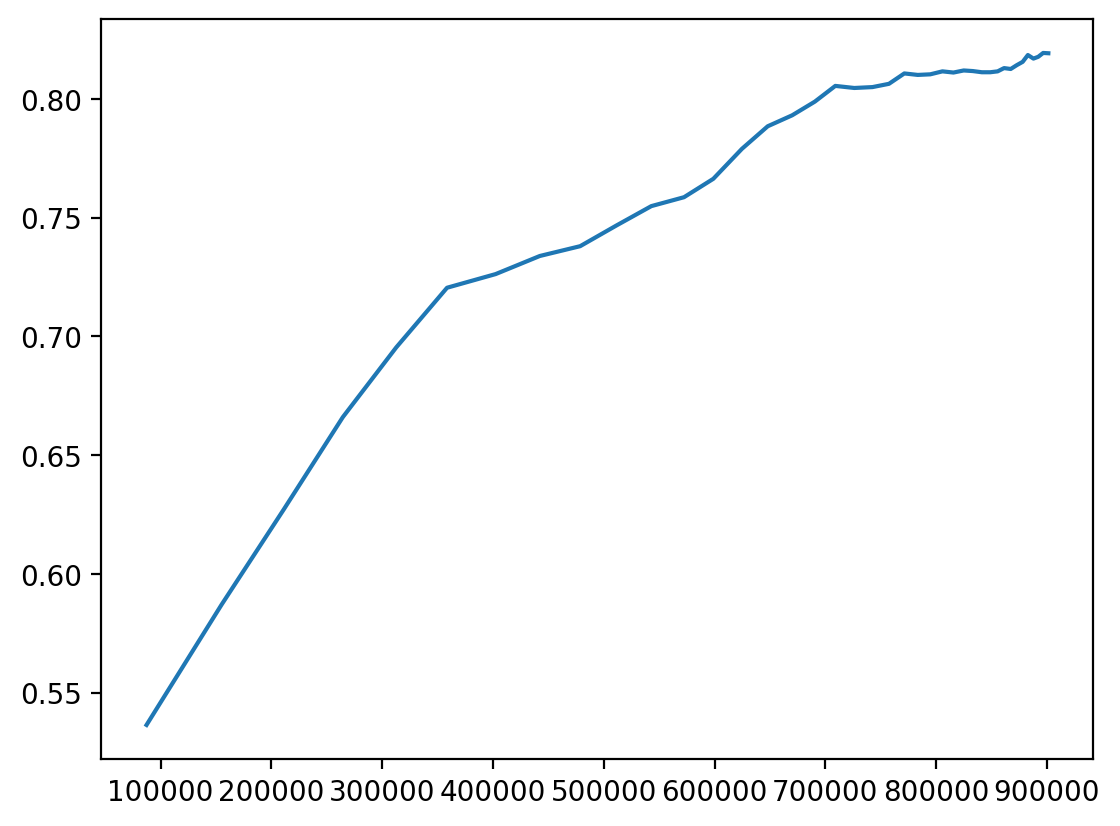

In [309]:
plt.plot(total_tokens, accs.mean(axis=1), label='Posthoc Acc')
# plt.plot(total_tokens_posthoc_acc, accs_posthoc_acc.mean(axis=1), label='Posthoc Acc')

## Ablation on including final ans string or not

In [326]:
thresholds = np.array([1.5 ** (-i) for i in range(0, 80)])
accs_entropy_and_token = {}
total_tokens_entropy_and_token = {}
tokens_entropy_and_token = {}
# include_final_ans_str_flag = [False, True, 'small', 'mixed']
include_final_ans_str_flag = [True, 'mixed', False, 'small']
EIDX = [1]
timescales = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3]

for include_final_ans in include_final_ans_str_flag:
    for timescale in timescales:
        for eidx in EIDX:
            accs_entropy_and_token[(timescale, eidx, include_final_ans)] = []
            total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = []
            tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = []
            for t in tqdm(thresholds):
                _accs = []
                _total_tokens = []
                for qid in range(MAX_RANGE):
                    if qid not in VALID_IDX:
                        continue
                    token_cost = reason_lengths[qid]
                    if include_final_ans == 'small':
                        acc, entropy = all_accs[qid], all_entropy_dpsk_small[qid][::2, eidx]
                        entropy2 = all_entropy_with_final_ans_dpsk_small[qid][::2, eidx]
                        entropy = entropy2
                    elif include_final_ans == 'mixed':
                        acc, entropy_1 = all_accs[qid], all_entropy[qid][::2, eidx]
                        entropy_2 = all_entropy_with_final_ans[qid][::2, eidx]
                        entropy = (entropy_1 + entropy_2) / 2
                    elif include_final_ans == True:
                        acc, entropy = all_accs[qid], all_entropy_with_final_ans[qid][::2, 1]
                    else:
                        acc, entropy = all_accs[qid], all_entropy[qid][:, eidx]
                    exit_idx = fine_line_with_max_token(token_cost, max_token=10000)

                    exit_idx_entropy = choose_early_stop_point(entropy, timescale, t, 25, min_value_threshold=None, normalize=False) 
                    
                    if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                        exit_idx_entropy = exit_idx
                    _total_tokens.append(token_cost[exit_idx_entropy])
                    _accs.append(acc[exit_idx_entropy])
                accs_entropy_and_token[(timescale, eidx, include_final_ans)].append(_accs)
                total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)].append(np.sum(_total_tokens))
                tokens_entropy_and_token[(timescale, eidx, include_final_ans)].append(_total_tokens)

            accs_entropy_and_token[(timescale, eidx, include_final_ans)] = np.array(accs_entropy_and_token[(timescale, eidx, include_final_ans)]).reshape(len(thresholds), len(VALID_IDX))
            total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = np.array(total_tokens_entropy_and_token[(timescale, eidx, include_final_ans)]).reshape(len(thresholds))
            tokens_entropy_and_token[(timescale, eidx, include_final_ans)] = np.array(tokens_entropy_and_token[(timescale, eidx, include_final_ans)]).reshape(len(thresholds), len(VALID_IDX))

  4%|█████▍                                                                                                                                           | 3/80 [00:00<00:03, 21.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 22.64it/s]


In [ ]:
total_tokens_entropy_and_token.keys()

dict_keys([(0.05, 1, True), (0.075, 1, True), (0.1, 1, True), (0.15, 1, True), (0.2, 1, True), (0.3, 1, True)])

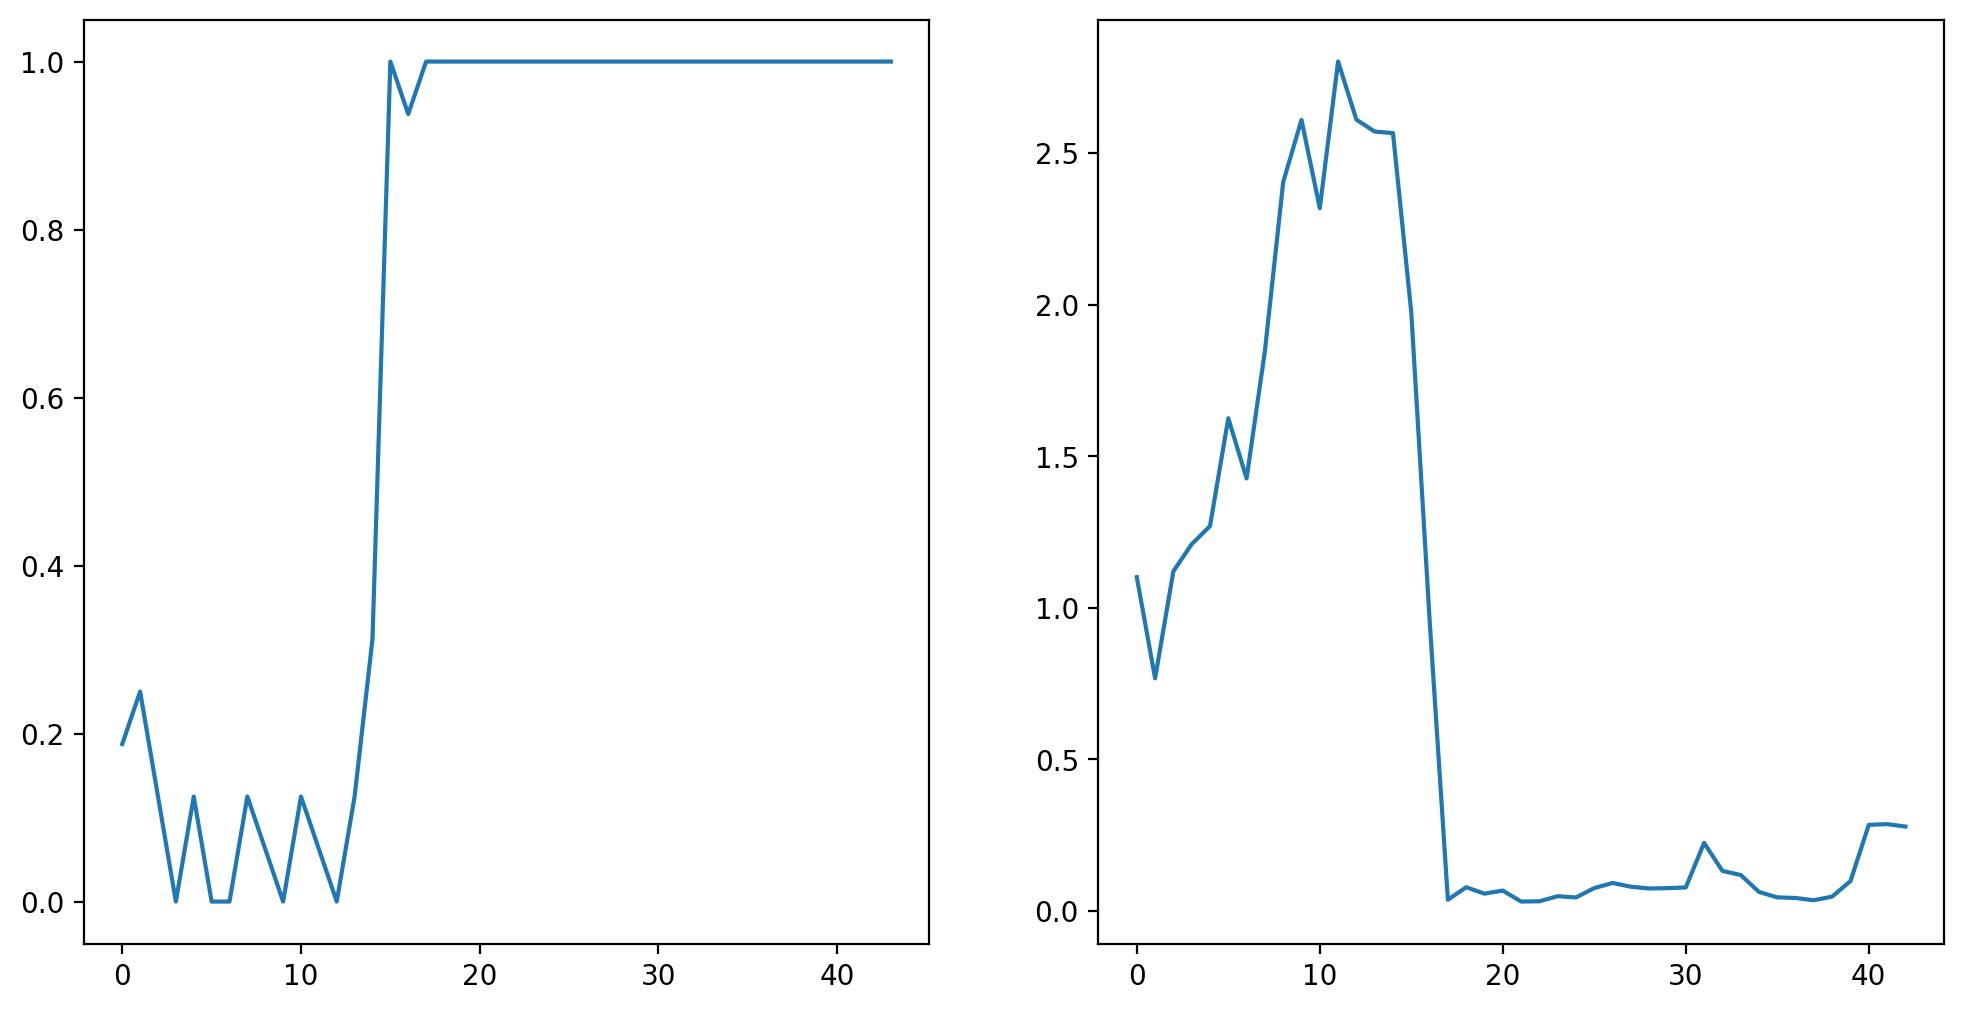

In [257]:
eidx = 1
qid = 15
# acc, entropy_1 = all_accs[qid], all_entropy[qid][::2, eidx]
# entropy_2 = all_entropy_with_final_ans[qid][::2, eidx]
# entropy = (entropy_1 + entropy_2) / 2

acc, entropy = all_accs[qid], all_entropy_dpsk_small[qid][::2, eidx]
entropy2 = all_entropy_with_final_ans_dpsk_small[qid][::2, eidx]
# entropy = (entropy + entropy2) / 2
entropy = entropy2

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(acc)
ax[1].plot(entropy)

(0.8, 0.825)

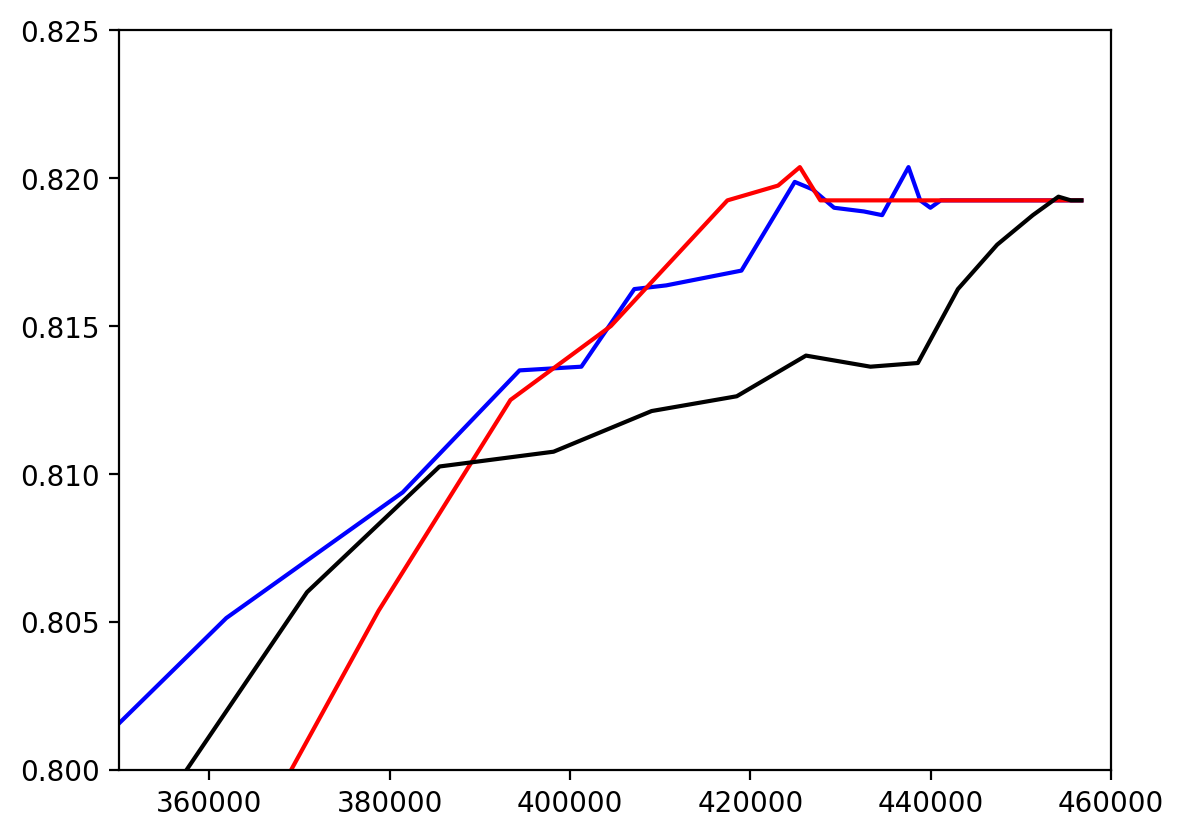

In [270]:
TT_dpsk_new = total_tokens_entropy_and_token[(0.2, 1, True)]
ACC_dpsk_new = accs_entropy_and_token[(0.2, 1, True)]
plt.plot(TT_dpsk_new, ACC_dpsk_new.mean(1), c='blue')

TT_dpsk_small = total_tokens_entropy_and_token[(0.2, 1, 'small')]
ACC_dpsk_small = accs_entropy_and_token[(0.2, 1, 'small')]
plt.plot(TT_dpsk_small, ACC_dpsk_small.mean(1), c='red')

plt.plot(total_tokens, accs.mean(1), color='black')
plt.xlim(3.5e5, 4.6e5)
plt.ylim(0.8, 0.825)

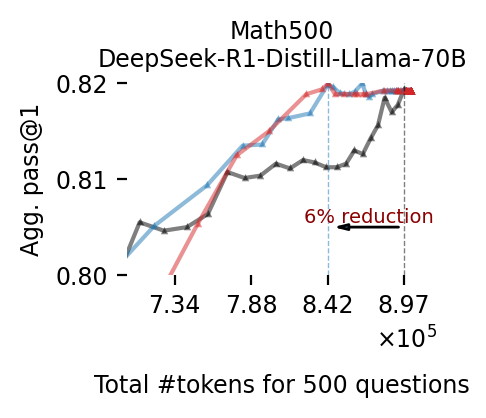

In [328]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(2.0, 2.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3,4,5])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

ax.plot(total_tokens, accs.mean(1), color='black',
    **line_config)


TT_dpsk_small = total_tokens_entropy_and_token[(0.2, 1, 'small')]
ACC_dpsk_small = accs_entropy_and_token[(0.2, 1, 'small')]


TT_dpsk_new = total_tokens_entropy_and_token[(0.2, 1, True)]
ACC_dpsk_new = accs_entropy_and_token[(0.2, 1, True)]


ax.plot(TT_dpsk_new, ACC_dpsk_new.mean(1), c=my_colors[0],
        linestyle='-',
        **line_config)

ax.plot(TT_dpsk_small, ACC_dpsk_small.mean(1), c=my_colors[3],
        linestyle='-',
        **line_config)

ax.set_xlim(7e5, 9.2e5)
ax.set_ylim(0.8, 0.82)

threshold = 0.819

blue_line_idx = TT_dpsk_new[np.argmax(ACC_dpsk_new.mean(1) > threshold)]
ax.axvline(blue_line_idx, color=my_colors[0], linestyle='--', linewidth=.5, alpha=0.5)

black_line_idx = total_tokens[np.argmax(accs.mean(1) > threshold)]
ax.axvline(black_line_idx, color='black', linestyle='--', linewidth=.5, alpha=0.5)

class ScalarFormatterForceFormat(mticker.ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.2f"  # Give format here

formatter = ScalarFormatterForceFormat(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)

ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel('Total #tokens for 500 questions', fontsize=FONT_SIZE, labelpad=20.0)
ax.set_title('Math500\nDeepSeek-R1-Distill-Llama-70B', fontsize=FONT_SIZE)
ax.set_box_aspect(0.618)

for a in ax.spines.values():
    a.set_visible(False)

y_target = 0.805

import matplotlib.patches as mpatches
arr = mpatches.FancyArrowPatch((black_line_idx, y_target), (blue_line_idx, y_target),
                               arrowstyle='-|>,head_width=.1',
                            # arrowstyle='simple',
                               mutation_scale=9)
ax.add_patch(arr)
ax.annotate("6% reduction",
    (.5, .5), xycoords=arr, ha='center', va='bottom',
    fontsize=7, color='darkred')


GAP_SIZE = black_line_idx - blue_line_idx
ax.set_xticks([blue_line_idx - 2 * GAP_SIZE, blue_line_idx - GAP_SIZE, blue_line_idx, black_line_idx])

ax.set_yticks([0.8, 0.81, 0.82])

fig.savefig('/root/figures/math500_llama70b.pdf', bbox_inches='tight')

In [315]:
(blue_line_idx - black_line_idx) / black_line_idx

np.float64(-0.0605123709396962)

In [301]:
(4.2 - 4.5) / 4.5

-0.06666666666666662